In [1]:
# this can be used to switch on/off warnings
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

#from google.colab import drive
#drive.mount('/content/gdrive/')

#!pip install --upgrade pip
#!pip install "czmodel>=3.0,<3.1"
#!pip install livelossplot scikit-learn xmltodict
#!pip install onnxruntime-gpu

# Train Simple U-Net for segmentation and use it inside ZEN

This notebook illustrates a **simple** workflow of training an ANN with [TensorFlow 2](https://www.tensorflow.org/) using the keras API and exporting the trained model to the [czmodel format](https://pypi.org/project/czmodel/) to be ready for use within the [Intellesis](https://www.zeiss.com/microscopy/int/products/microscope-software/zen-intellesis-image-segmentation-by-deep-learning.html) software inside ZEN.

* **The trained model is for demo purposes and trained on a small dataset.**
* **Therefore, this notebook is meant to be understood as a guide for exporting trained models**
* **The notebook does not show how train a model correctly.**

In [2]:
# imports to train a simple TF2 + Keras model for segmentation

import os
#os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
from sklearn.model_selection import train_test_split

import sys
print("Current Directory:", os.getcwd())
#sys.path.append('/content/gdrive/MyDrive/Colab Notebooks/train_czann')
sys.path.append(os.getcwd())

from tools._model import build_model
from livelossplot import PlotLossesKerasTF

# Optional: suppress TF warnings
import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)
print(tf.version.GIT_VERSION, tf.__version__)
print("# GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Current Directory: c:\Users\m1srh\Documents\Github\czimetadata_tools\examples\pylibCZIrw_docu
v2.8.0-rc1-32-g3f878cff5b6 2.8.0
# GPUs Available:  1


## Training Pipeline
This section describes a **simple** training procedure that creates a trained Keras model - in this case a U-Net.

* Therefore, the pipelin only represents one possible custom training procedure.
* Such procedure will vary from case to case and will contain more sophisticated ways to generate an optimized model

In [3]:
# Define the parameters for loading the training data

# adjust to jour needs
#base_directory = r"/content/gdrive/MyDrive/Colab Notebooks/train_czann"
base_directory = os.getcwd()

# place the original and label *.png images here
imgfolder = "nucleus_data/images/"

# masks images have one channel (0=background and 1=object)
maskfolder = 'nucleus_data/label/'

modelfolder = "trained_models"

# construct the final path to the images and labels
IMAGES_FOLDER = os.path.join(base_directory, imgfolder)
MASKS_FOLDER = os.path.join(base_directory, maskfolder)

In [4]:
# define the number of channels inside the image to be segmented
CHANNELS = 1

# define bit depth for images  and masks
BITDEPTH_IMAGES = tf.dtypes.uint16
BITDEPTH_MASKS = tf.dtypes.uint16

# the model contains 2 classes, eg. object and background
NUM_CLASSES = 2

# tilesize for training which depends on the GPU memory size etc.
SZTR = 384
#SZTR = 256

# Model and Training Parameters
KERNEL_SIZE = 3
DROPOUT = 0.15
LEARNING_RATE = 1e-3
BATCHSIZE = 1

In [5]:
# define very simple augumentation function - can be extented as needed
def random_crop_and_pad_image_and_label(image, label, size):
    """Randomly crops image together with labels.

    Args:
      image: A Tensor with shape [D_1, ..., D_K, N]
      label: A Tensor with shape [D_1, ..., D_K, M]
      size: A Tensor with shape [K] indicating the crop size.
    Returns:
      A tuple of (cropped_image, cropped_label).
    """
    
    combined = tf.concat([image, label], axis=-1)
    image_shape = tf.shape(image)
    combined_pad = tf.image.pad_to_bounding_box(combined, 0, 0,
                                                tf.maximum(size[0], image_shape[0]),
                                                tf.maximum(size[1], image_shape[1]))
    
    last_label_dim = tf.shape(label)[-1]
    last_image_dim = tf.shape(image)[-1]
    
    combined_crop = tf.image.random_crop(combined_pad,
                                         size=tf.concat([size, [last_label_dim + last_image_dim]],
                                                        axis=0))
    
    return (combined_crop[:, :, :last_image_dim], combined_crop[:, :, last_image_dim:])



In [6]:
# helper function to reorder labels incase of multiple classes
def reorder_labels(mask):
    for i, unique_value in enumerate(np.unique(mask)):
        mask[mask == unique_value] = i
    return mask

def order_unique_values(mask):
    for i, unique_value in enumerate(np.unique(mask)):
        mask[mask == unique_value] = i
    return mask

In [7]:
# This part contains the logic to read pairs of images and label masks for training.

# get the sample images
sample_images = sorted([os.path.join(IMAGES_FOLDER, f) for f in os.listdir(IMAGES_FOLDER)
                        if os.path.isfile(os.path.join(IMAGES_FOLDER, f))])

# get the maks
sample_masks = sorted([os.path.join(MASKS_FOLDER, f) for f in os.listdir(MASKS_FOLDER)
                       if os.path.isfile(os.path.join(MASKS_FOLDER, f))])

# Load images as numpy arrays and scale to interval [0..1]
images_loaded = np.asarray(
    [
        tf.image.decode_image(
            tf.io.read_file(sample_path), channels=CHANNELS, dtype=tf.uint16
        ).numpy().astype(np.float32) / (2**16 - 1)
        for sample_path in sample_images
    ]
)

In [8]:
# Normalize images
images_mean = images_loaded.mean(axis=(0,1,2))
images_std = images_loaded.std(axis=(0,1,2))
images_loaded = (images_loaded - images_mean) / images_std

masks_loaded = [tf.image.decode_image(tf.io.read_file(sample_path), dtype=BITDEPTH_MASKS).numpy()[...,0] for sample_path in sample_masks]

# load masks and create one_hot encoded masks
masks_loaded = [tf.convert_to_tensor(order_unique_values(mask_loaded).astype(np.uint8)) for mask_loaded in masks_loaded]
masks_loaded = np.asarray([tf.one_hot(mask_loaded, depth=NUM_CLASSES).numpy() for mask_loaded in masks_loaded])

# Remark: For details see [tf.one_hot](https://www.tensorflow.org/api_docs/python/tf/one_hot)
# tf.one_hot creates X channels from X labels: 1 => [0.0, 1.0], 0 => [1.0, 0.0]`

In [9]:
# split the datasets into training, test and validation sets
def split_datasets(images, shuffel=False, testsize=0.2):
    
    # split into train and test set
    train, test = train_test_split(images, shuffle=False, test_size=testsize)
    
    # split training set into final training set and validation set
    train, val = train_test_split(train, shuffle=False, test_size=testsize)
    
    return train, test, val

# do the splitting
images_train, images_test, images_val = split_datasets(images_loaded, testsize=0.2)
masks_train, masks_test, masks_val = split_datasets(masks_loaded, testsize=0.2) 

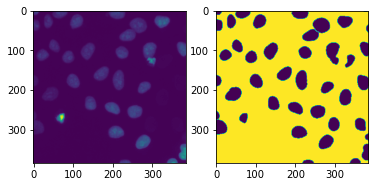

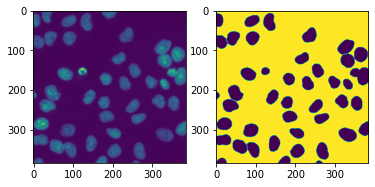

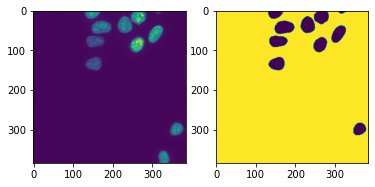

In [10]:
# check if the images fit to the labels - always a good idea ... :-)

#pair2show = len(images_loaded)
pair2show = 3

for i in range(pair2show):
    
    # cut out a smaller image for visualization
    cropped_image, cropped_mask = random_crop_and_pad_image_and_label(image=images_loaded[i, ...],
                                                                      label=masks_loaded[i, ...],
                                                                      size=[SZTR, SZTR])
  
    # show the images next to the labels
    fig, (ax1, ax2) = plt.subplots(1, 2)
    ax1.imshow(cropped_image[...,0])
    ax2.imshow(cropped_mask[...,0])

In [11]:
# create a tfdatasets from the images and masks
tfdataset = tf.data.Dataset.from_tensor_slices((images_loaded, masks_loaded))
tfdataset_train = tf.data.Dataset.from_tensor_slices((images_train, masks_train))
tfdataset_test = tf.data.Dataset.from_tensor_slices((images_test, masks_test))
tfdataset_val = tf.data.Dataset.from_tensor_slices((images_val, masks_val))

# apply the augmentation function to the tfdataset = just a random crop and create batch datasets 

# complete set
tfdataset = tfdataset.map(lambda image, label: random_crop_and_pad_image_and_label(image,
                                                                                   label,
                                                                                   size=[SZTR, SZTR])).batch(BATCHSIZE)

# train set
tfdataset_train = tfdataset_train.map(lambda image, label: random_crop_and_pad_image_and_label(image,
                                                                                               label,
                                                                                               size=[SZTR, SZTR])).batch(BATCHSIZE)
# test set
tfdataset_test = tfdataset_test.map(lambda image, label: random_crop_and_pad_image_and_label(image,
                                                                                             label,
                                                                                             size=[SZTR, SZTR])).batch(BATCHSIZE)
# validation set
tfdataset_val = tfdataset_val.map(lambda image, label: random_crop_and_pad_image_and_label(image,
                                                                                           label,
                                                                                           size=[SZTR, SZTR])).batch(BATCHSIZE)

In [12]:
# generate th U-Net model
model = build_model(start_filters=16,
                    numchannels=CHANNELS,
                    numclasses=NUM_CLASSES,
                    learning_rate=LEARNING_RATE,
                    perimagestd=False,
                    kernelsize=KERNEL_SIZE,
                    dropout=DROPOUT
                   )

# show model summary (optional)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 1)]                                                              
                                                                                                  
 conv2d (Conv2D)                (None, None, None,   160         ['input_1[0][0]']                
                                16)                                                               
                                                                                                  
 batch_normalization (BatchNorm  (None, None, None,   64         ['conv2d[0][0]']                 
 alization)                     16)                                                           

                                                                                                  
 activation_6 (Activation)      (None, None, None,   0           ['batch_normalization_6[0][0]']  
                                128)                                                              
                                                                                                  
 conv2d_7 (Conv2D)              (None, None, None,   147584      ['activation_6[0][0]']           
                                128)                                                              
                                                                                                  
 batch_normalization_7 (BatchNo  (None, None, None,   512        ['conv2d_7[0][0]']               
 rmalization)                   128)                                                              
                                                                                                  
 activatio

                                64)                                                               
                                                                                                  
 batch_normalization_13 (BatchN  (None, None, None,   256        ['conv2d_13[0][0]']              
 ormalization)                  64)                                                               
                                                                                                  
 activation_13 (Activation)     (None, None, None,   0           ['batch_normalization_13[0][0]'] 
                                64)                                                               
                                                                                                  
 up_sampling2d_2 (UpSampling2D)  (None, None, None,   0          ['activation_13[0][0]']          
                                64)                                                               
          

### Fit the model to the loaded data
This part fits the model to the loaded data and evaluates it on the training data. In this test example we do not care about an actual evaluation of the model using validation and test data sets.

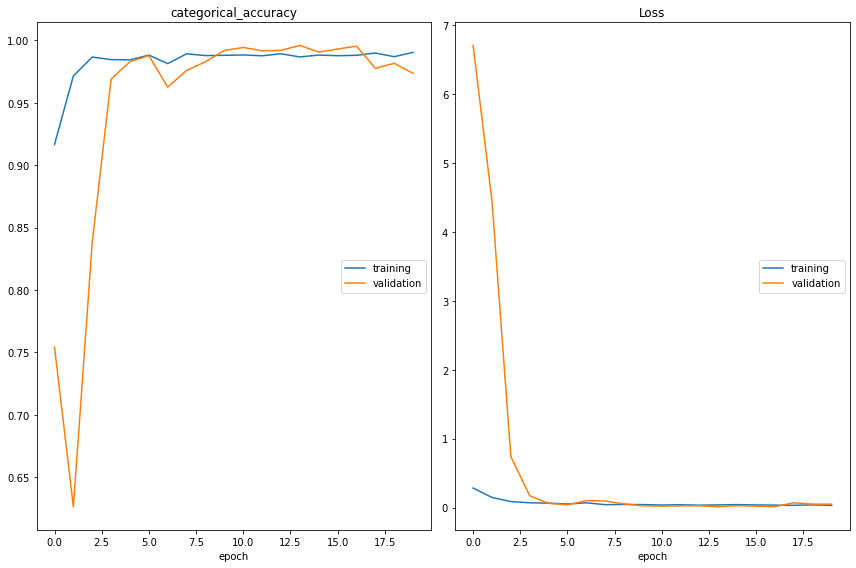

categorical_accuracy
	training         	 (min:    0.917, max:    0.990, cur:    0.990)
	validation       	 (min:    0.626, max:    0.996, cur:    0.974)
Loss
	training         	 (min:    0.032, max:    0.284, cur:    0.032)
	validation       	 (min:    0.013, max:    6.706, cur:    0.051)
24/24 [==============================] - 1s 58ms/step - loss: 0.0319 - categorical_accuracy: 0.9904 - val_loss: 0.0506 - val_categorical_accuracy: 0.9736


In [13]:
# train the U-Net model

# define number of training epochs
num_epochs = 20

# fit the model to the data using the "training" set and for validataion the "validation" set
model.fit(tfdataset_train,
          callbacks=[PlotLossesKerasTF()],
          validation_data=(tfdataset_val),
          epochs=num_epochs)

In [14]:
# get the loss and accuary values
loss, accuracy = model.evaluate(tfdataset_test)

# show the final accuracy achieved on the "test" set which was never used for "anything" so far
print("The model achieves {}% accuracy on the test data.".format(accuracy * 100))

8/8 [==============================] - 0s 24ms/step - loss: 0.0369 - categorical_accuracy: 0.9864
The model achieves 98.64349365234375% accuracy on the test data.


In [15]:
# create an iterator for the dataset
dataset_it = iter(tfdataset_test)

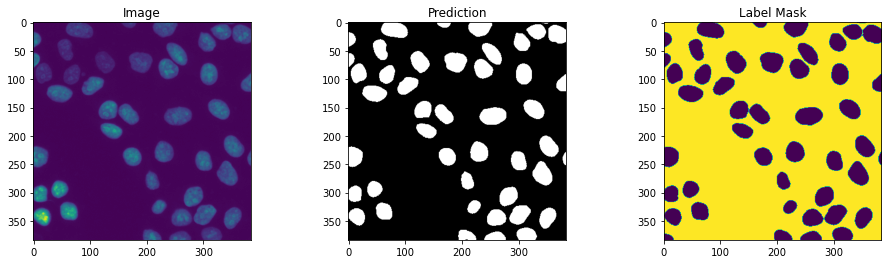

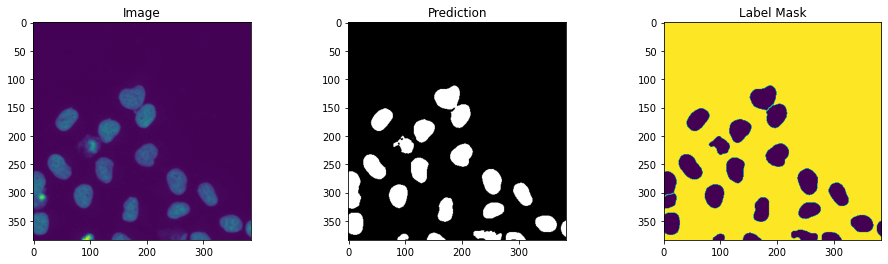

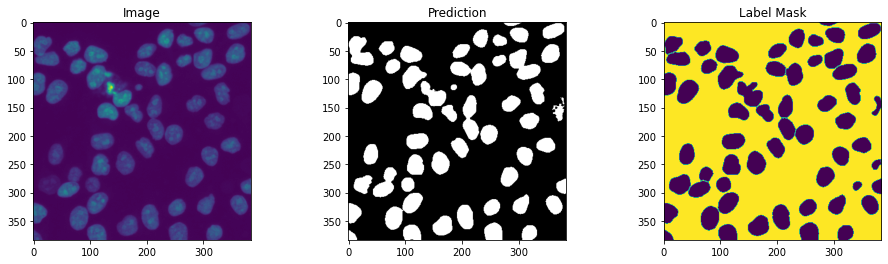

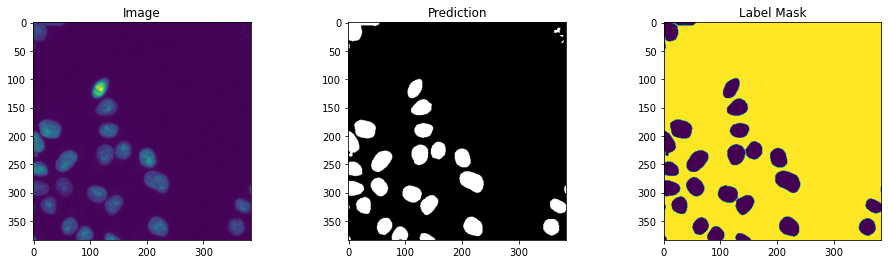

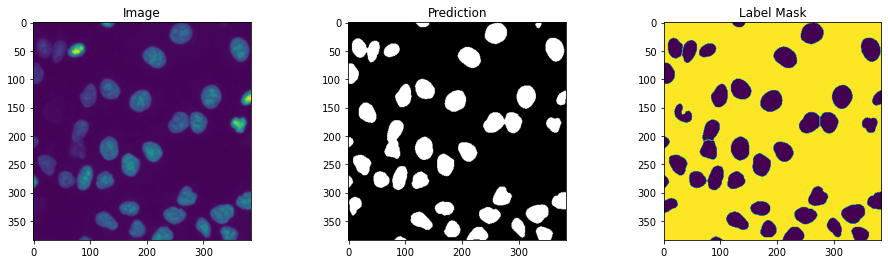

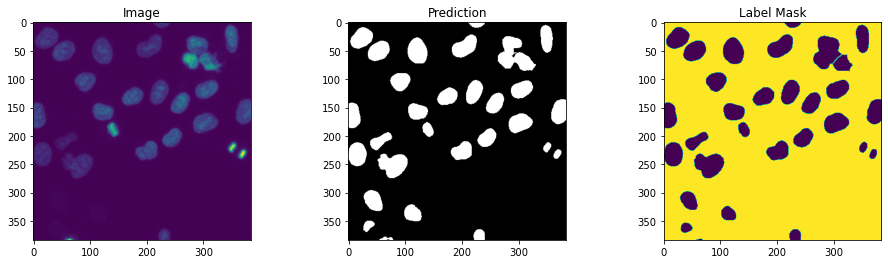

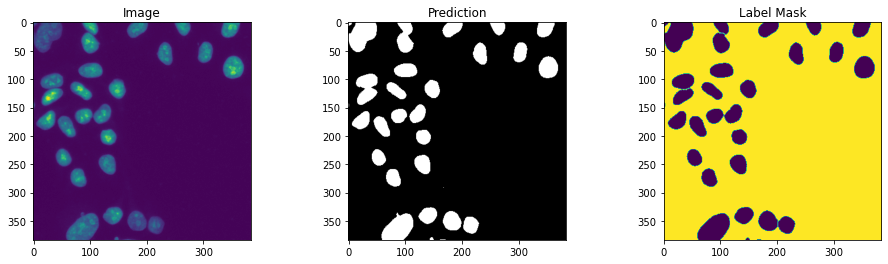

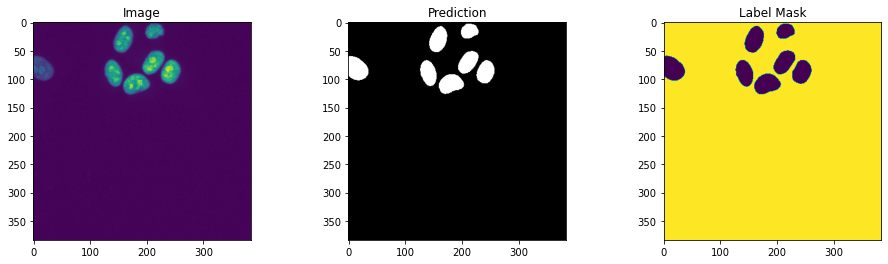

In [16]:
# get an image and a mask from the dataset
for img, mask in dataset_it:

    #run the prediction and get the masks using argmax
    pred = model.predict(img)[0]
    pred = np.argmax(pred, axis=-1)

    # scale the image and shwo the results - just re-execute the cell to display a different image
    img_scaled = img.numpy()[0] / img.numpy().max()
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
    fig.set_figwidth(16)

    # show images and set titles
    ax1.imshow(img_scaled[...,0])
    ax2.imshow(pred, cmap="gray", vmin=0, vmax=1)
    ax3.imshow(mask[0,...,0])

    ax1.set_title('Image')
    ax2.set_title('Prediction')
    ax3.set_title('Label Mask')

## Create a CZModel from the trained Keras model

In this section we export the trained model to the CZModel format using the czmodel library and some additional meta data all possible parameter choices are described in the [ANN model specification](https://pypi.org/project/czmodel/) that can be found on the PyPi packager for `czmodel`.

### Define Meta-Data

We first define the meta-data needed to run the model within the Intellesis infrastructure. The `czmodel` package offers a named tuple `ModelMetadata` that allows to either parse as JSON file as described or to directly specify the parameters as shown below.

### Create a Model Specification Object

The export functions provided by the `czmodel` package expect a `ModelSpec` tuple that features the Keras model to be exported and the corresponding model metadata.

Therefore, we wrap our model and the `model_metadata` instance into a `ModelSpec` object.

In [17]:
# Function provided by the PyPI package called czmodel (by ZEISS)
from czmodel.model_metadata import ModelMetadata, ModelSpec, ModelType
from czmodel.legacy_model_metadata import ModelMetadata as LegacyModelMetadata, ModelSpec as LegacyModelSpec
from czmodel import DefaultConverter, LegacyConverter
from czmodel.util.transforms import Shift, Scale

# Define dimensions - ZEN Intellesis requires fully defined spatial dimensions in the meta data of the CZANN model.
# The ZEN TilingClient uses the input shape in the meta data to infer the tile size to pass an image to the inferencer.
# Important: The tile size has to be chosen s.t. inference is possible with the minimum hardware requirements of Intellesis
# Optional: Define target spatial dimensions of the model for inference.
input_size = 1024

# Define the model metadata
model_metadata = ModelMetadata(
    input_shape=[input_size, input_size, 1],
    output_shape=[input_size, input_size, 2],
    model_type=ModelType.SINGLE_CLASS_SEMANTIC_SEGMENTATION,
    classes=["Background", "Nucleus"],
    model_name="Simple_Nuclei_SegmentationModel",
    min_overlap=[128, 128],
)
model_spec = ModelSpec(
    model=model,
    model_metadata=model_metadata,
    license_file=None
)

model_metadata_legacy = LegacyModelMetadata(
    name="Simple_Nuclei_SegmentationModel_Legacy",
    classes=["Background", "Nucleus"],
    pixel_types="Gray16",
    color_handling="SplitRgb",
    border_size=128,
)
model_spec_legacy = LegacyModelSpec(
    model=model,
    model_metadata=model_metadata_legacy,
    license_file=None
)

# Define pre-processing
preprocessing = [
    Shift(-images_mean),
    Scale(1.0 / images_std)
]
preprocessing_legacy = [ # Mean and sandard deviation must be scaled according to the bit depth of the input images
    Shift(-images_mean * (2**16 - 1)),
    Scale((2**16 - 1) / images_std)
]

### Perform model export into *.czann / *.czseg file format

The converters from the `czmodel` library offers two functions to perform the actual export. 

* `convert_from_json_spec` allows to provide a JSON file containing all the information of a ModelSpec object and converts a model in SavedModel format on disk to a `.czann` / `.czseg` file that can be loaded with ZEN.
* `convert_from_model_spec` expects a `ModelSpec` object, an output path and name and optionally target spatial dimensions for the expected input of the exported model. From this information it creates a `.czann` / `.czseg` file containing the specified model.

Currently, `czmodel` offers two converters:
* DefaultConverter: Converts a model to a *.czann file.
* LegacyConverter: Converts a model to a *.czseg file (legacy format).

In [18]:
DefaultConverter().convert_from_model_spec(
    model_spec=model_spec, 
    output_path=os.path.join(base_directory, modelfolder), 
    output_name='simple_nuclei_segmodel',
    spatial_dims=(input_size, input_size),
    preprocessing=preprocessing
)

# In the example above there will be a ""./czmodel_output/simple_nuclei_segmodel.czann" file saved on disk.

'--tag' not specified for saved_model. Using --tag serve
'--signature_def' not specified, using first signature: serving_default


In [19]:
LegacyConverter().convert_from_model_spec(
    model_spec=model_spec_legacy, 
    output_path=os.path.join(base_directory, modelfolder), 
    output_name='simple_nuclei_segmodel_legacy',
    spatial_dims=(input_size, input_size),
    preprocessing=preprocessing_legacy
)

'--tag' not specified for saved_model. Using --tag serve
'--signature_def' not specified, using first signature: serving_default


## Remarks
The generated .czann and .czseg files can be directly loaded into ZEN Intellesis to perform segmentation tasks with the trained model.
If there is already a trained model in SavedModel format present on disk, it can also be converted by providing the path to the saved model directory instead of a Keras `Model` object. The `czmodel` library will implicitly load the model from the provided path.

The `czmodel` library also provides a `convert_from_json_spec` function that accepts a JSON file with the above mentioned meta data behind the key `ModelMetadata` which will implicitly be deserialized into a `ModelMetadata` object, the model path and optionally a license file:
```json
{
    "ModelMetadata": {
        "Type": "SingleClassSemanticSegmentation",
        "Classes": ["Background", "Nucleus"],
        "InputShape": [1024, 1024, 1],
        "OutputShape": [1024, 1024, 2],
        "ModelName": "Nuclei Segmentation Model From JSON",
        "MinOverlap": [128, 128]
    },
    "ModelPath": "./saved_tf2_model_output/",
    "LicenseFile": null
}
```

This information can be copied to a file e.g. in the current working directory `./model_conversion_spec.json` that also contains the trained model in SavedModel format e.g. generated by the following line:

In [ ]:
# save the trained TF2.SavedModel as a folder structure
# The folder + the JSON file can be also used to import the model in ZEN

model.save(os.path.join(os.path.join(base_directory, modelfolder), './saved_tf2_model_output/'))

In [ ]:
tf.keras.backend.clear_session()